<h1 align="center">Machine Learning Project : Face Recognition System</h1>

#### Authors :

* Aurélien Tournade
* Claire Penot
* Martin Collard
* Adam Chellaoui
* Basma Belahcen

In [1]:
# Imports
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from matplotlib import patches
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Table of contents

[1. Definiton of the CNN model](#chapter1)

[2. Face recognition for faces of same size](#chapter2)
   * [2.1 Iteration over the big image](#21)
   * [2.2 Clustering the predictions](#22)
   * [2.3 Display rectangles arround faces (cluster centers)](#23)
    
[3. Face recognition for faces of different sizes](#chapter3)
   * [3.1 Resized Images](#32)
   * [3.2 Going through the pyramid ](#32)
   * [3.3 Display the centers detected](#33)
   * [3.4 Second clustering to get only one center for each face](#34)
   * [3.5 Display the center and the edges of faces](#35)

# 1. Definiton of the CNN model <a class="anchor" id="chapter1"></a>

#### We choose to use a Convolutional neural network because it is more fit for image data. Indeed, CNN allow to reduce the number of units in the network, which means fewer parameters to learn and reduced chance of overfitting. Also, with the convolution and padding layers, CNN captures local patterns in the image and retrieve features like shape, edges, or orienttion, by learning image features using small squares of input data.

#### We choose to use zero-padding in order to keep the latent image representation the bigger possible (9x9), it allows for more space for the kernel to cover the image, and results in more accurate analysis of images.

In [2]:
# Network, ready to use
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2, padding_mode='zeros')
        self.pool = nn.MaxPool2d(2, 2) #Pooling 2 by 2, window of 2
        self.conv2 = nn.Conv2d(32, 64, 5 , padding=2, padding_mode='zeros')
        self.fc1 = nn.Linear(64 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [3]:
# Network creation
net = Net()

In [4]:
# Calculate Entropy error -> test accuracy of model, we want criterion to tend to 0.
# Optimize change network each time to make it better. It's ran between every batches

# we want to perfrom classification so we choose the cross-entropy loss
criterion = nn.CrossEntropyLoss()

# we choose the stochastic gradient descent as optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
# The model has already been trained (on a dataset of 36x36 pixel images in black and white) and saved, so we load it directly :
net = torch.load("./Saved Models/model_95_test.pt")
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=5184, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=2, bias=True)
)

# 2. Face recognition for faces of same size <a class="anchor" id="chapter2"></a>

## 2.1 Iteration over the big image <a class="anchor" id="21"></a>

In [6]:
originalImage = cv2.imread('./Images Visages/martin.jpg')
image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)/255.

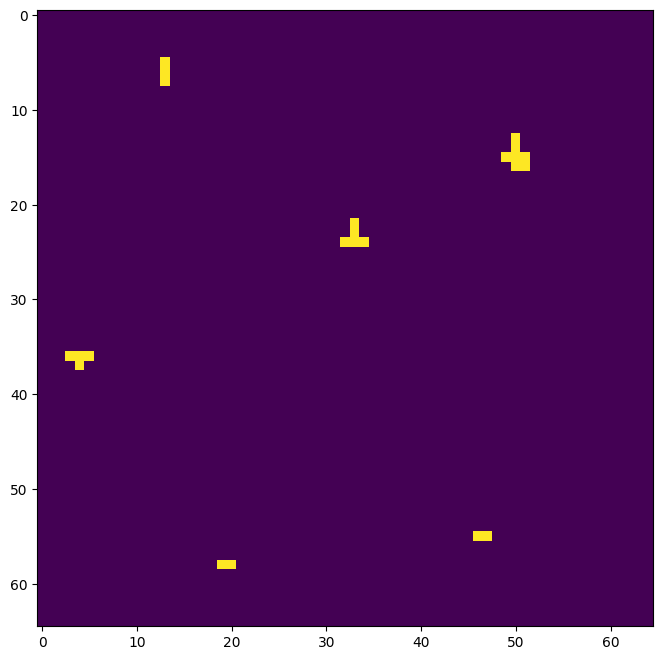

In [7]:
step = 5
size = 36
whole_size = 360
nb_windows = int((whole_size - size + 1)/step)
mat = np.zeros((nb_windows,nb_windows))
cpt = 0
for i in range(nb_windows) :
    for j in range(nb_windows) :
        #cpt+=1
        small_image = image[(step*i):(step*i)+size, (step*j):(step*j)+size]
        #print(cpt, small_image.shape)
        torch_image = torch.from_numpy(small_image).type(torch.FloatTensor)
        torch_image = torch.unsqueeze(torch_image, dim=0)
        torch_image = torch.unsqueeze(torch_image, dim=0)
        outputs = net(torch_image)
        _, predicted = torch.max(outputs.data, 1)
        mat[i][j] = predicted
plt.figure(figsize=(10,8))
plt.imshow(mat)
plt.show()

## 2.2 Clustering the predictions <a class="anchor" id="22"></a>

array([[ 88, 268],
       [133, 183],
       [198,  38],
       [ 48,  83],
       [308, 113],
       [293, 248]])

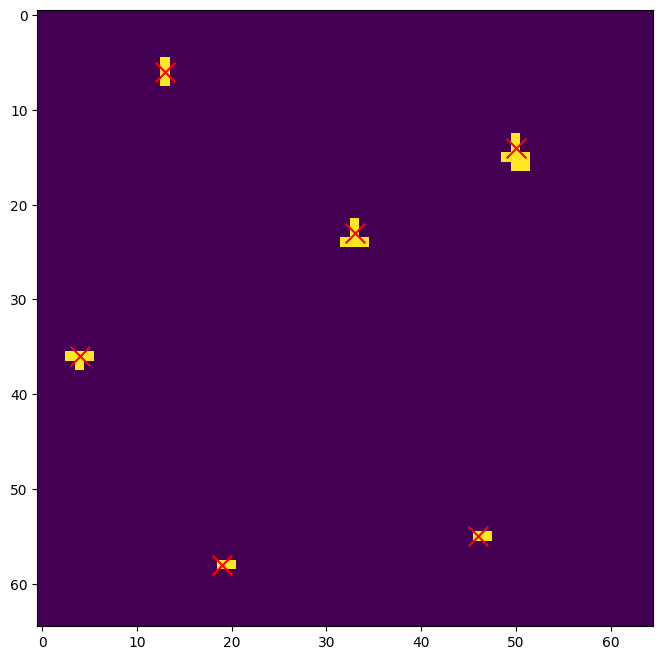

In [8]:
#cluster
array_of_points = [[i, j] for i in range(nb_windows) for j in range(nb_windows) if mat[i][j] == 1]

X = np.array(array_of_points)

clustering = MeanShift(bandwidth=3).fit(X)
centers = clustering.cluster_centers_
#centers = np.reshape(clustering.cluster_centers_, (nb_windows, nb_windows))
centers_faces = centers.astype(int)
plt.figure(figsize=(10,8))
plt.imshow(mat)
plt.scatter(centers_faces[:, 1], centers_faces[:, 0], marker="x", color="red", s=200)

#mat_centers = np.zeros((whole_size, whole_size))
#for idx, coord in enumerate(array_of_points):
centers_faces = centers_faces*step + int(size/2)
centers_faces

## 2.3 Display rectangles arround faces (cluster centers) <a class="anchor" id="23"></a>

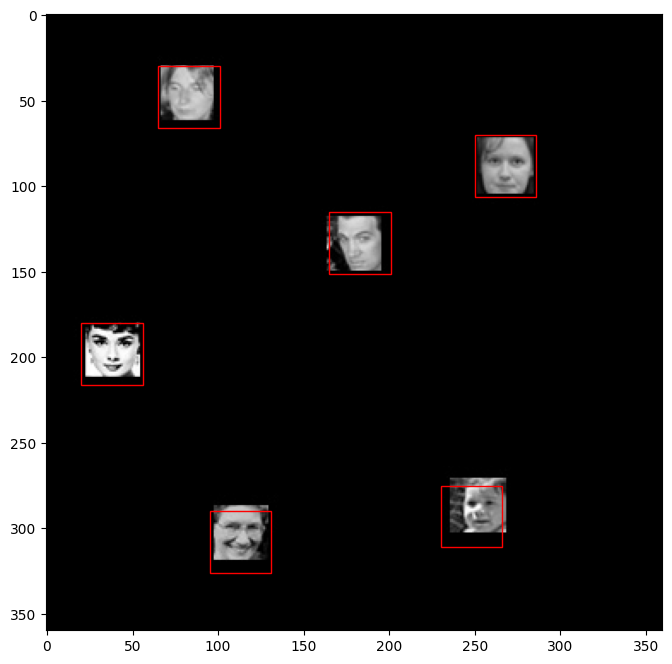

In [9]:
plt.figure(figsize=(10,8))
plt.imshow(originalImage)

top_right_corners = np.array(centers_faces)
top_right_corners[:, 1] -= int(size/2)
top_right_corners[:, 0] -= int(size/2)

#plt.scatter(top_right_corners[:, 1], top_right_corners[:, 0], marker="x", color="red", s=200)
ax = plt.gca()

for [x,y] in top_right_corners:
    rect = patches.Rectangle((y,x), size, size, linewidth=1, edgecolor = 'r', facecolor='none')
    ax.add_patch(rect)


# 3. Face recognition for faces of different sizes <a class="anchor" id="chapter3"></a>
## 3.1 Resized Images <a class="anchor" id="31"></a>
#### In order to detect larger faces than 36x36 pixels, we create smaller resized images by a factor of 20%, on which we will iterate with our initial model.

Resized Dimensions :  (360, 360)
1
Resized Dimensions :  (288, 288)
2
Resized Dimensions :  (230, 230)
3
Resized Dimensions :  (184, 184)
4


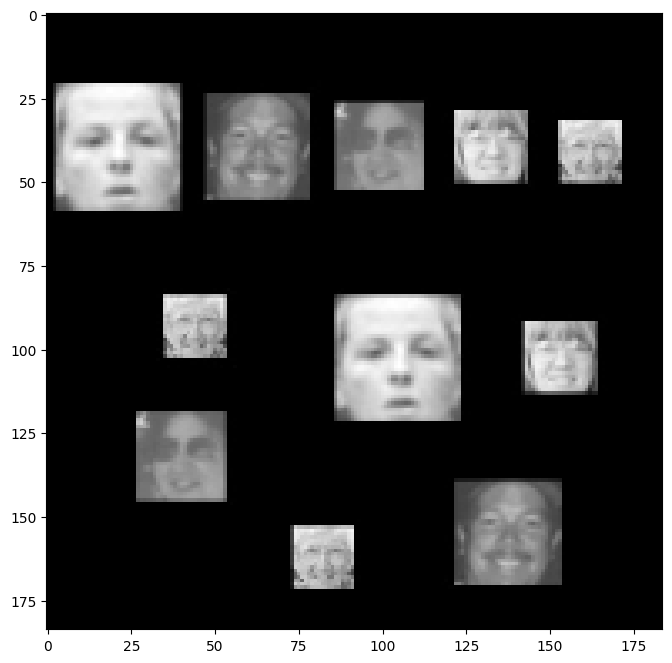

In [10]:
pyramid = []

plt.figure(figsize=(10,8))
img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.

resized_factors = [1/(0.8 ** i) for i in range(0,4)]

for resized_factor in resized_factors :

    width = int(img.shape[1] / resized_factor)
    height = int(img.shape[0] / resized_factor)
    dim = (width, height)

    # resize image
    new_img = cv2.resize(img, dim)
    print('Resized Dimensions : ', new_img.shape)

    plt.imshow(new_img, cmap='gray')

    pyramid.append(new_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print(len(pyramid))

### Method to find the real centers of faces for each resized factor

In [11]:
def get_face_centers(array_of_points, resised_factor):
    X = np.array(array_of_points)
    clustering = MeanShift(bandwidth=20, max_iter=500).fit(X)
    centers = clustering.cluster_centers_
    centers_faces = centers.astype(int)

    # return the center and the resized_factor
    real_face_size = np.repeat(resised_factor*size, len(centers))
    centers_faces = np.c_[centers_faces, real_face_size]

    return centers_faces

## 3.2 Going through the pyramid <a class="anchor" id="32"></a>

#### We iterate over the four resized images to detect faces of different sizes. We save the prediction in order to display them later.

In [12]:
step = 5
size = 36
whole_size = 360
nb_windows = int((whole_size - size + 1)/step)
mat = np.zeros((360,360))
all_centers = None

for index, resized_factor in enumerate(resized_factors) :
    image = pyramid[index]
    whole_size = image.shape[0]
    nb_windows = int((whole_size - size + 1)/step)
    array_of_points_to_cluster = []

    for i in range(nb_windows) :
        for j in range(nb_windows) :
            center_window_x = step*i+size//2
            center_window_y = step*j+size//2

            small_image = image[(step*i):(step*i)+size, (step*j):(step*j)+size]

            torch_image = torch.from_numpy(small_image).type(torch.FloatTensor)
            torch_image = torch.unsqueeze(torch_image, dim=0)
            torch_image = torch.unsqueeze(torch_image, dim=0)

            outputs = net(torch_image)
            _, predicted = torch.max(outputs.data, 1)

            if predicted == 1:
                array_of_points_to_cluster.append([int(center_window_x * resized_factor), int(center_window_y  * resized_factor)])

    # get the centers_faces with the real size of the face
    current_centers = get_face_centers(array_of_points_to_cluster, resized_factor)
    #print(current_centers)
    all_centers = np.concatenate((all_centers, current_centers), axis=0) if all_centers is not None else current_centers

#print(all_centers)


## 3.3 Display the centers detected <a class="anchor" id="33"></a>

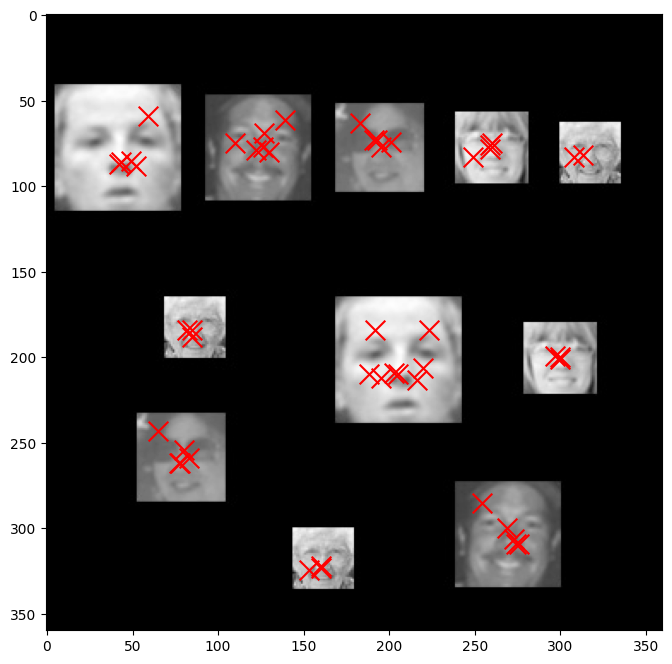

In [13]:
img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.
plt.figure(figsize=(10,8))
plt.imshow(img, cmap='gray')
plt.scatter(all_centers[:, 1], all_centers[:, 0], marker="x", color="red", s=200)
plt.show()

## 3.4 Second clustering to get only one center for each face <a class="anchor" id="34"></a>

### Method to cluster the centers and return the corresponding size of the face

In [14]:
def get_face_definitive_centers(array_of_points):
    X = np.array(array_of_points)
    clustering = MeanShift(bandwidth=30).fit(X[:,0:2])
    centers = clustering.cluster_centers_
    centers_faces = centers.astype(int)
    sizes = X[:,2]


    # Mapping each cluster with a size

    ## The value is a tuple to compute the avg size
    clusterSizeMap_ = {cluster:[0,0] for cluster in range(len(centers))}

    for point, cluster in enumerate(clustering.labels_):
        clusterSizeMap_[cluster][0] += sizes[point]
        clusterSizeMap_[cluster][1] += 1

    ## Computing the average size value
    clusterSizeMap = {cluster:value[0]//value[1] for cluster, value in clusterSizeMap_.items()}

    return centers_faces, clusterSizeMap

In [15]:
definitive_centers, size_corres = get_face_definitive_centers(all_centers)

## 3.5 Display the center and the edges of faces <a class="anchor" id="35"></a>
#### The centers :

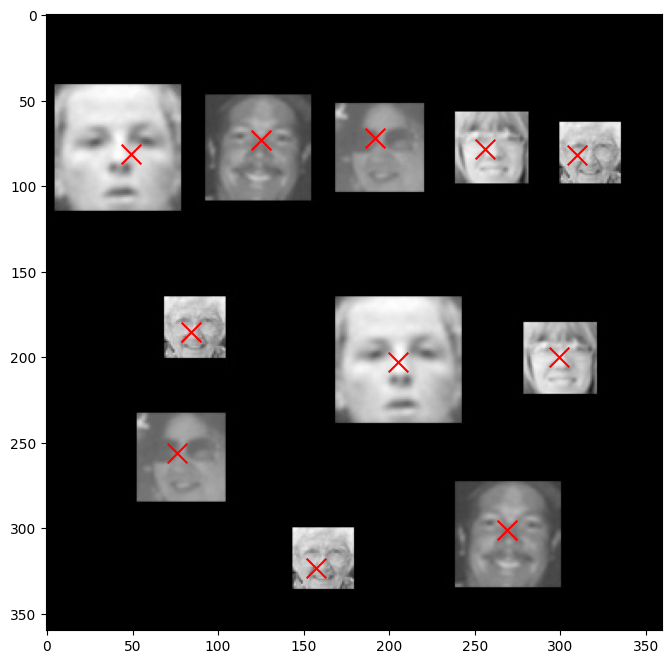

In [16]:
img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.
plt.figure(figsize=(10,8))
plt.imshow(img, cmap='gray')
plt.scatter(definitive_centers[:, 1], definitive_centers[:, 0], marker="x", color="red", s=200)
plt.show()

#### The edges :

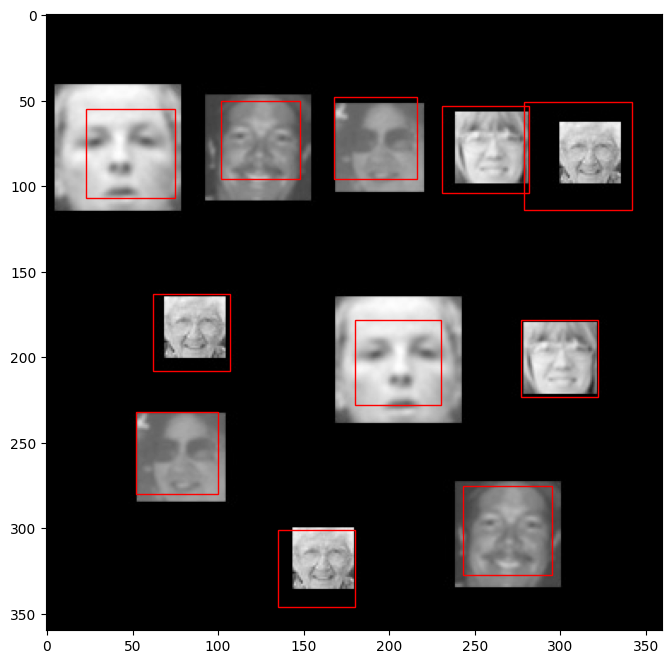

In [17]:
img = cv2.imread('./Images Visages/Pyramid big faces black.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.
plt.figure(figsize=(10,8))
plt.imshow(img, cmap='gray')

top_right_corners = np.array(definitive_centers)
for row in range(len(top_right_corners)):
    size = size_corres[row]
    top_right_corners[row,0] -= int(size/2)
    top_right_corners[row,1] -= int(size/2)

# drawing rectangles
ax = plt.gca()
for row, [x,y] in enumerate(top_right_corners):
    size = size_corres[row]
    rect = patches.Rectangle((y,x), size, size, linewidth=1, edgecolor = 'r', facecolor='none')
    ax.add_patch(rect)